In [1]:
# importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import math
import numpy as np

#ML
from sktime.classification.feature_based import RandomIntervalClassifier

# metrics
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

/home/apetrella/miniconda3/envs/battery_tsc/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# general parameters
len_series = 100  # the leght max of the time series

In [45]:
# Create Nasa Dataframe

#import dataset
# list_cells= ['B0005','B0006','B0007','B0018']
list_cells= ['B0005','B0006','B0007']
nasa_dataset={}
for cell in list_cells:
    cell_dataset = scipy.io.loadmat('dataset/Nasa/5. Battery Data Set/DS/'+ cell +'.mat', simplify_cells=True)
    del cell_dataset["__header__"]
    del cell_dataset["__version__"]
    del cell_dataset["__globals__"]
    
    nasa_dataset[cell] = cell_dataset[cell]


# divide the dataset in 3 parts: charge, discharge and impedance
# in this work, we used only the charge part
 
nasa_dict={}

# for each cell
for cell in list_cells:
    nasa_dict[cell]={}
    nasa_dict[cell]['charge'] = []
    nasa_dict[cell]['discharge'] = []
    nasa_dict[cell]['impedance'] = []

    # save into the right part of dict
    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' and key > 1 ):   # non cago il primo di ogni cella che vaneggia...
            nasa_dict[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' ):
            nasa_dict[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' ):
            nasa_dict[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    
    # to calculate the SoH, we need to know the capacity. we save the capacity information from discharge to charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        
        if (k < len(nasa_dict[cell]['discharge'])):
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['charge'][k-1]['SoH']


    #from capacity to SoH
    # the first one is 100, and the other ones are calculated
    start_Ah= 0
    for k,v in enumerate(nasa_dict[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict[cell]['charge'][k]['SoH'] 
            nasa_dict[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict[cell]['charge'][k]['SoH'] = int(round(nasa_dict[cell]['charge'][k]['SoH'] / start_Ah * 100))


    #convert array in panda series, it is nedded to use sktime.
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_measured'][:len_series])
        nasa_dict[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Temperature_measured'][:len_series])

        

# unify, the dataset, as a unique battery/cell
nasa_dict_unify={}
nasa_dict_unify['charge'] = []

for cell in list_cells:
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict_unify['charge'].append(v)


df_nasa= pd.DataFrame(nasa_dict_unify['charge'])

#rimuovo dati "non interessanti"(che non voglio usare)
df_nasa=df_nasa.drop("Current_charge",axis=1)
df_nasa=df_nasa.drop("Voltage_charge",axis=1)
df_nasa=df_nasa.drop("Time",axis=1)
df_nasa=df_nasa.drop("Current_measured",axis=1)

df_nasa

,Voltage_measured,Temperature_measured,SoH
0,0 3.325055 1 3.001951 2 3.434644 3...,0 29.341851 1 29.335723 2 29.33471...,100
1,0 3.352604 1 3.035879 2 3.459468 3...,0 29.553301 1 29.538751 2 29.53900...,99
2,0 3.378799 1 3.066145 2 3.485569 3...,0 29.456340 1 29.436998 2 29.43251...,99
3,0 3.372871 1 3.063766 2 3.478147 3...,0 29.481334 1 29.461955 2 29.46636...,99
4,0 3.366775 1 3.059322 2 3.471082 3...,0 29.395820 1 29.389419 2 29.38870...,99
...,...,...,...
502,0 3.683275 1 3.468906 2 3.810765 3...,0 25.797539 1 25.798393 2 25.80155...,74
503,0 3.681613 1 3.467195 2 3.808857 3...,0 25.892449 1 25.882426 2 25.88463...,74
504,0 3.684054 1 3.469601 2 3.811252 3...,0 25.886973 1 25.881281 2 25.89140...,75
505,0 3.691533 1 3.477083 2 3.821317 3...,0 24.614346 1 24.605708 2 24.61751...,76


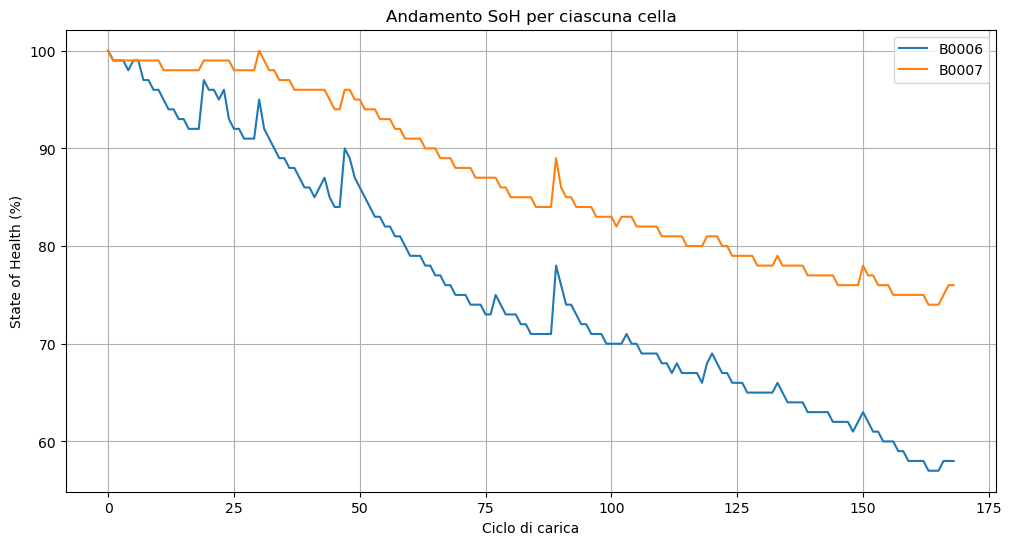

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for cell in list_cells:
    soh = [cycle['SoH'] for cycle in nasa_dict[cell]['charge']]
    plt.plot(soh, label=cell)

plt.xlabel("Ciclo di carica")
plt.ylabel("State of Health (%)")
plt.title("Andamento SoH per ciascuna cella")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_174225/3307405789.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_nasa, x='cell', y='Voltage_mean', palette="Set2")


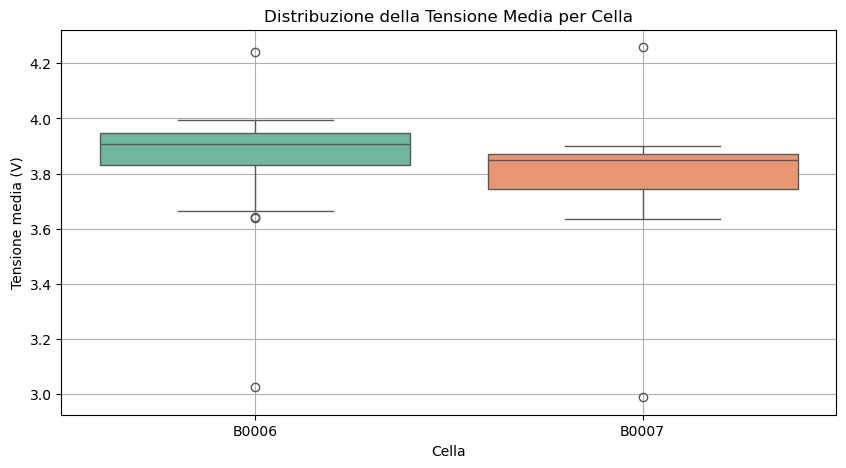

/tmp/ipykernel_174225/3307405789.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_nasa, x='cell', y='Temperature_mean', palette="Set3")


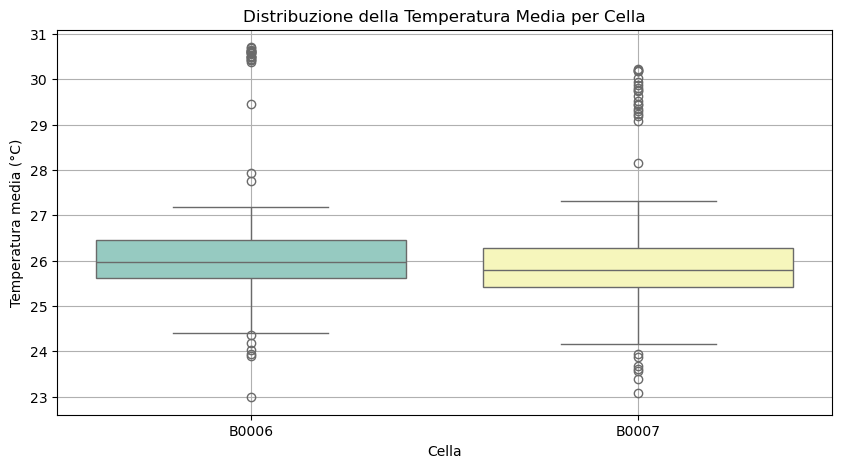

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ricostruisci la colonna 'cell' per sapere a quale cella appartiene ogni ciclo
cell_labels = []
for cell in list_cells:
    n_cycles = len(nasa_dict[cell]['charge'])
    cell_labels.extend([cell] * n_cycles)

df_nasa['cell'] = cell_labels

# Step 2: Crea nuove colonne per la media della tensione e temperatura
df_nasa['Voltage_mean'] = df_nasa['Voltage_measured'].apply(lambda x: x.mean())
df_nasa['Temperature_mean'] = df_nasa['Temperature_measured'].apply(lambda x: x.mean())

# Step 3: Boxplot della tensione media per cella
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_nasa, x='cell', y='Voltage_mean', palette="Set2")
plt.title("Distribuzione della Tensione Media per Cella")
plt.ylabel("Tensione media (V)")
plt.xlabel("Cella")
plt.grid(True)
plt.show()

# Step 4: Boxplot della temperatura media per cella
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_nasa, x='cell', y='Temperature_mean', palette="Set3")
plt.title("Distribuzione della Temperatura Media per Cella")
plt.ylabel("Temperatura media (°C)")
plt.xlabel("Cella")
plt.grid(True)
plt.show()

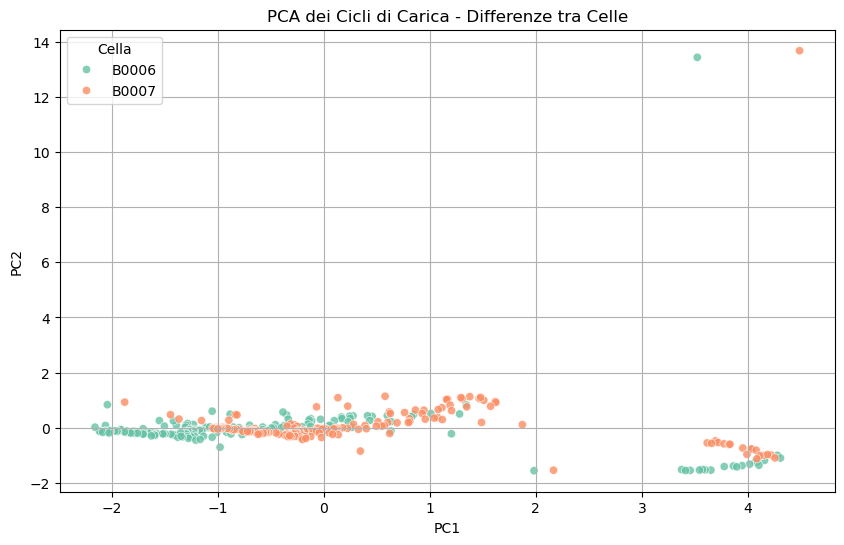

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ricostruzione etichetta cella (se non l'hai ancora fatto)
cell_labels = []
for cell in list_cells:
    n_cycles = len(nasa_dict[cell]['charge'])
    cell_labels.extend([cell] * n_cycles)

df_nasa['cell'] = cell_labels

# Crea feature statistiche per ogni ciclo
df_pca = pd.DataFrame({
    'Voltage_mean': df_nasa['Voltage_measured'].apply(np.mean),
    'Voltage_std': df_nasa['Voltage_measured'].apply(np.std),
    'Temperature_mean': df_nasa['Temperature_measured'].apply(np.mean),
    'Temperature_std': df_nasa['Temperature_measured'].apply(np.std),
    'SoH': df_nasa['SoH'],
    'cell': df_nasa['cell']
})

# Pre-processing: normalizzazione
features = ['Voltage_mean', 'Voltage_std', 'Temperature_mean', 'Temperature_std', 'SoH']
x = StandardScaler().fit_transform(df_pca[features])

# PCA
pca = PCA(n_components=2)
components = pca.fit_transform(x)

# Aggiungi i componenti al dataframe
df_pca['PC1'] = components[:, 0]
df_pca['PC2'] = components[:, 1]

# Plot dei componenti principali
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cell', palette='Set2', alpha=0.8)
plt.title('PCA dei Cicli di Carica - Differenze tra Celle')
plt.grid(True)
plt.legend(title='Cella')
plt.show()

In [47]:
# Create Nasa Dataframe for the test

#import dataset
list_cells= ['B0018']
nasa_dataset={}
for cell in list_cells:
    cell_dataset = scipy.io.loadmat('dataset/Nasa/5. Battery Data Set/DS/'+ cell +'.mat', simplify_cells=True)
    del cell_dataset["__header__"]
    del cell_dataset["__version__"]
    del cell_dataset["__globals__"]
    
    nasa_dataset[cell] = cell_dataset[cell]


# divide the dataset in 3 parts: charge, discharge and impedance
# in this work, we used only the charge part
 
nasa_dict_test={}

# for each cell
for cell in list_cells:
    nasa_dict_test[cell]={}
    nasa_dict_test[cell]['charge'] = []
    nasa_dict_test[cell]['discharge'] = []
    nasa_dict_test[cell]['impedance'] = []

    # save into the right part of dict
    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' and key > 1 ):   # non cago il primo di ogni cella che vaneggia...
            nasa_dict_test[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' ):
            nasa_dict_test[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' ):
            nasa_dict_test[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    
    # to calculate the SoH, we need to know the capacity. we save the capacity information from discharge to charge
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        
        if (k < len(nasa_dict_test[cell]['discharge'])):
            nasa_dict_test[cell]['charge'][k]['SoH'] = nasa_dict_test[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict_test[cell]['charge'][k]['SoH'] = nasa_dict_test[cell]['charge'][k-1]['SoH']


    #from capacity to SoH
    # the first one is 100, and the other ones are calculated
    start_Ah= 0
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict_test[cell]['charge'][k]['SoH'] 
            nasa_dict_test[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict_test[cell]['charge'][k]['SoH'] = int(round(nasa_dict_test[cell]['charge'][k]['SoH'] / start_Ah * 100))


    #convert array in panda series, it is nedded to use sktime.
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        nasa_dict_test[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict_test[cell]['charge'][k]['Voltage_measured'][:len_series])
        nasa_dict_test[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict_test[cell]['charge'][k]['Temperature_measured'][:len_series])

        

# unify, the dataset, as a unique battery/cell
nasa_dict_unify={}
nasa_dict_unify['charge'] = []

for cell in list_cells:
    # unisco charge
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        nasa_dict_unify['charge'].append(v)


df_nasa_test= pd.DataFrame(nasa_dict_unify['charge'])

#rimuovo dati "non interessanti"(che non voglio usare)
df_nasa_test=df_nasa_test.drop("Current_charge",axis=1)
df_nasa_test=df_nasa_test.drop("Voltage_charge",axis=1)
df_nasa_test=df_nasa_test.drop("Time",axis=1)
df_nasa_test=df_nasa_test.drop("Current_measured",axis=1)

df_nasa_test

,Voltage_measured,Temperature_measured,SoH
0,0 3.342650 1 2.968585 2 3.479525 3...,0 24.257341 1 24.254969 2 24.28687...,100
1,0 3.345141 1 3.000746 2 3.468806 3...,0 26.229758 1 26.228845 2 26.25258...,99
2,0 3.366405 1 3.022063 2 3.488725 3...,0 25.679914 1 25.680276 2 25.70108...,99
3,0 3.441460 1 3.081311 2 3.568832 3...,0 23.577299 1 23.577854 2 23.61173...,99
4,0 3.184015 1 2.892021 2 3.281728 3...,0 36.186651 1 36.153460 2 36.13005...,99
...,...,...,...
128,0 3.487453 1 3.168863 2 3.546760 3...,0 33.872568 1 33.787686 2 33.78767...,73
129,0 3.494356 1 3.175670 2 3.556132 3...,0 34.158881 1 34.082038 2 34.07254...,73
130,0 3.515781 1 3.194762 2 3.578757 3...,0 33.942370 1 33.866384 2 33.85798...,73
131,0 3.685647 1 3.327417 2 3.775247 3...,0 25.102520 1 25.103878 2 25.19299...,72


In [48]:
# remove if time series has a different lenght
# there is time series more shorter than len_series 
for index, row in df_nasa.iterrows():
    if(len(row['Temperature_measured']) != len_series ):  
        df_nasa = df_nasa.drop(index)
        print('drop')
for index, row in df_nasa_test.iterrows():
    if(len(row['Temperature_measured']) != len_series ):  
        df_nasa_test = df_nasa_test.drop(index)
        print('drop')

drop
drop
drop


In [49]:
# divide dataset in train set and test set


x_train = df_nasa
y_train = x_train['SoH'].copy().astype('int')
x_train = x_train.drop(columns=['SoH'])

x_test = df_nasa_test
y_test = x_test['SoH'].copy().astype('int') 
x_test = x_test.drop(columns=['SoH'])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(504, 2) (504,)
(133, 2) (133,)


In [50]:
# random interval

clf = RandomIntervalClassifier(n_intervals=5,random_state=1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
# y_pred

MAE% = 0.02875495158795532
MAE = 2.505952380952381
RMSE = 3.1613363660084666


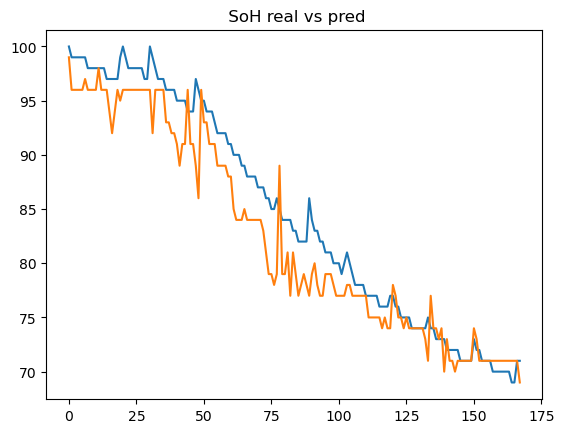

In [8]:
# plot and metrics

print('MAE% = ' + str(mean_absolute_percentage_error(y_test, y_pred)))
print('MAE = ' + str(mean_absolute_error(y_test, y_pred)))
print('RMSE = ' + str(np.sqrt(np.square(np.subtract(y_test,y_pred)).mean())))


plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

MAE% = 0.04437964230480941
MAE = 0.03714285714285716
RMSE = 0.049086900589911046


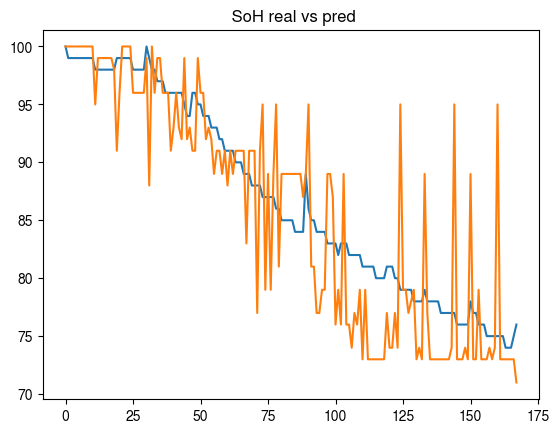

In [36]:
y_test_norm = [x / 100 for x in y_test]
y_pred_norm = [y / 100 for y in y_pred]

# plot and metrics

print('MAE% = ' + str(mean_absolute_percentage_error(y_test_norm, y_pred_norm)))
print('MAE = ' + str(mean_absolute_error(y_test_norm, y_pred_norm)))
print('RMSE = ' + str(np.sqrt(np.square(np.subtract(y_test_norm,y_pred_norm)).mean())))


plt.title(" SoH real vs pred")
plt.plot(y_test)
plt.plot( y_pred)
plt.show()

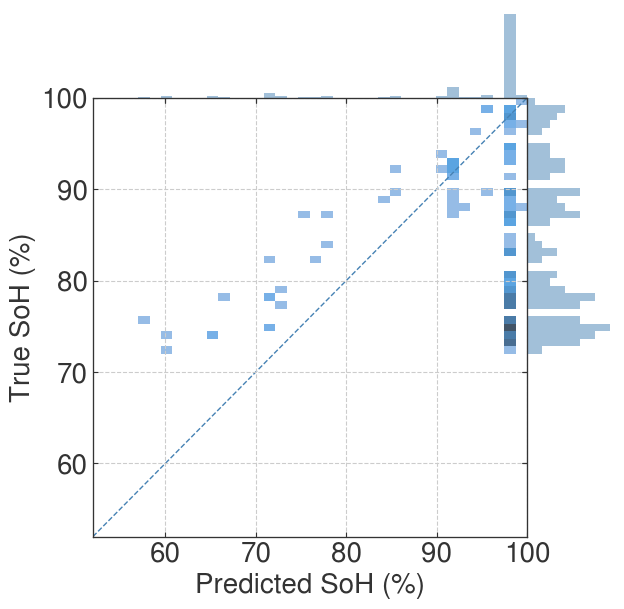

In [51]:
# PLOTIING ADDED FOR R2

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams.update({'font.family': 'Nimbus Sans'})  # sostituisci con 'Nimbus Sans L' o 'Liberation Sans'

real_pred = {
    'real': y_test.values,
    'pred': y_pred
}
df_plot = pd.DataFrame(real_pred)

#colors = ["#F0741E", "#276CB3"]

colors = ["#4682B4", "#FF0000"]


class_names = np.union1d(np.unique(df_plot['real']), np.unique(df_plot['pred']))

g = sns.jointplot(
    x="pred", 
    y="real", 
    data=df_plot, 
    kind="hist", 
    marginal_kws={"color": colors[0], "bins": len(class_names), "edgecolor": None, "linewidth": 0, "alpha":0.5},
    joint_kws={"color": colors[0], "bins": len(class_names), "edgecolor": None, "linewidth": 0, },
    space=0
)

# Scala fissa
g.ax_joint.set_xlim([52, 100])
g.ax_joint.set_ylim([52, 100])

# Tick principali
ticks = np.arange(60, 101, 10)
g.ax_joint.set_xticks(ticks)
g.ax_joint.set_yticks(ticks)
g.ax_joint.tick_params(axis="both", which="major", labelsize=20, colors="#333333", direction="in")

#Grid
g.ax_joint.grid(True, which='major', linestyle='--', color='#CCCCCC', zorder=0)

# Aggiungere la linea y = x
g.ax_joint.plot([52, 100], [52, 100], color=colors[0], linestyle='--', linewidth=1.0, zorder=1)

# Assi duplicati: sopra e destra
ax_top = g.ax_joint.twiny()
ax_right = g.ax_joint.twinx()
ax_top.set_xlim(g.ax_joint.get_xlim())
ax_right.set_ylim(g.ax_joint.get_ylim())
ax_top.set_xticks(ticks)
ax_right.set_yticks(ticks)
ax_top.set_xticklabels([])
ax_right.set_yticklabels([])

ax_top.tick_params(axis='x', colors="#333333", direction="in")
ax_right.tick_params(axis='y', colors="#333333", direction="in")

# Spine grigie scure
for spine in g.ax_joint.spines.values():
    spine.set_color("#333333")
for spine in ax_top.spines.values():
    spine.set_color("#333333")
for spine in ax_right.spines.values():
    spine.set_color("#333333")

# Labels principali
g.ax_joint.set_xlabel('Predicted SoH (%)', fontsize=20, color="#333333")
g.ax_joint.set_ylabel('True SoH (%)', fontsize=20, color="#333333")

plt.savefig('plot/cell18_100_nasa_8515__R2.png', dpi=300, bbox_inches="tight")
plt.show()

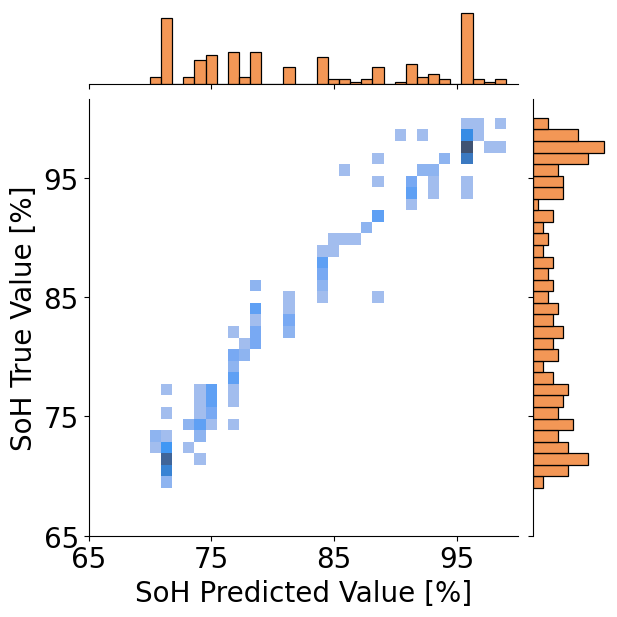

In [11]:
# plotting

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


real_pred = {
    'real':y_test.values,
    'pred':y_pred
}
df_plot = pd.DataFrame(real_pred)

colors = ["#F0741E", "#276CB3"]

class_names = np.union1d(np.unique(df_plot['real']), (np.unique(df_plot['pred'])))


g = sns.jointplot(x="pred", 
                  y="real", 
                  data=df_plot, 
                  kind="hist", 
                  marginal_kws={"color": colors[0], "bins":len(class_names)},
                  joint_kws={"color": colors[1], "bins": len(class_names)} 
                  )


g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
ticks = np.arange(65, 101, 10)
labels = [f'{x}' for x in ticks]
g.ax_joint.set_xlim([min(class_names),max(class_names)])
g.ax_joint.set_yticks(ticks,labels=labels)
g.ax_joint.set_xticks(ticks,labels=labels)

g.set_axis_labels(
    'SoH Predicted Value [%]', 'SoH True Value [%]' ,fontsize=20
)

plt.savefig('plot/100_nasa_oxford.png', dpi=300, bbox_inches="tight")